## Intensity-Modulated Scanning Kelvin Probe Microscopy (IM-SKPM)

A simple package for simulating IM-SKPM in photovoltaics based on conventional charge density recombination ODE. 

This approach simulates equations of the form:

$\frac {dn} {dt} = G-k_1n -k_2n^2-k_3n^3$

where:
* $n$ = carrier density (#$/cm^3$)
* $\frac {dn} {dt} $ = change in carrier density (#$/{cm^3s}$)
* $G$ = generation rate (#$/cm^3$)
* $k_1$ = monomoecular recombination rate ($/s$), trapping/nonradiative recombination
* $k_2$ = bimolecular recombination rate ($cm^3/s$), band-band/radiative recombination
* $k_3$ = third order recombination rate ($cm^6/s$), Auger recombination

See, for example:
deQuilettes,et al. "Charge-Carrier Recombination in Halide Perovskites." Chemical Reviews **119**, 11007-11019 (2019).[DOI:10.1021/acs.chemrev.9b00169.](https://doi.org/10.1021/acs.chemrev.9b00169)

###### Package location:
* [IMSKPM](https://github.com/rajgiriUW/imskpm/)

###### Installation instructions:

* Clone or download the code from the link above (it is not on PyPi or other package sites...yet)
* In a command window, navigate to the folder where this is installed, then type:
```python setup.py```
or 
```python setup.py develop```

###### For more information:
```
Rajiv Giridharagopal, Ph.D.
University of Washington
rgiri@uw.edu
```

In [1]:
import imskpm

C:\Users\raj\anaconda3\lib\site-packages\igor-0.3-py3.8.egg\igor\util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\raj\anaconda3\lib\site-packages\igor-0.3-py3.8.egg\igor\util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?


### Simulating a single IM-SKPM curve

There are two main Classes in the code as currently constructed, an ```IMSKPMPoint``` class and a ```IMSKPMSweep``` class that inherits IMSKPMPoint. Meaning, ```IMSKPMSweep``` calls the ```IMSKPMPoint``` Constructor and contains a superset of the same child functions. Both are very short (<400 lines), so I highly recommend you look through the functions to see what is going on.

Here is the set of (current) initial parameters when calling IMSKPMPoint:
```
intensity = 0.1,
k1 = 1e6,
k2 = 1e-10,
k3 = 0,
thickness = 500e-7
```

The IMSKPMPoint calls a few other functions:
```
kinetics(k1, k2, k3, absorbance = 1)
exc_source(intensity, wl=455e-9, NA=0.6)
make_pulse()
```

These set up the various parameters.
* ```kinetics(..)``` just assigns those values to the internal ```self.k1, self.k2, self.k3``` variables if you want to change them. 
* ```exc_source(..)``` defines the incident excitation source light area + wavelength. 
* ```make_pulse(..)``` creates a single light pulse. Here, the rise time and fall time for the pulse could be specified. Otherwise, the carrier density is calculated assuming the light is a step function (but the resultant carrier junction won't be, of course). You specify the timings 

The actual simulation is called by ```simulate```, which itself calls one of the functions in ```odes```. The default is ```dn_dt_g``` which is the simple rate equation in the first cell. But, you can supply anything.

In [2]:
from imskpm.imskpmpoint import IMSKPMPoint
device = IMSKPMPoint()
frequency = 100 # 100 Hz
device.make_pulse(0,0,pulse_time = 1/frequency, start_time = 1/(4*frequency), pulse_width = 1/(1/2*frequency))
device.simulate()


C:\Users\raj\Documents\Coding\imskpm\imskpm\imskpmpoint.py:168: UserWarning: Pulse exceeds total_time, cropping width to match
  warnings.warn('Pulse exceeds total_time, cropping width to match')
C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: overflow encountered in power
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3
C:\Users\raj\Documents\Coding\imskpm\imskpm\odes.py:68: RuntimeWarning: invalid value encountered in multiply
  n_dot = g - k1 * n - k2 * n**2 - k3 * n**3


(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Carriers generated, intensity=100.0 $mW/cm^2$'}, xlabel='Time ($\\mu$s)', ylabel='Carrier Density ($cm^{-3}$)'>)

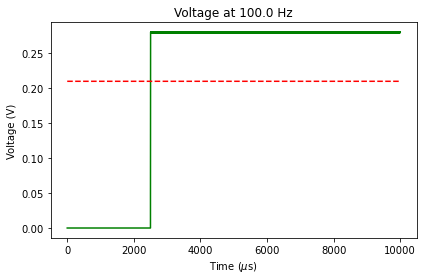

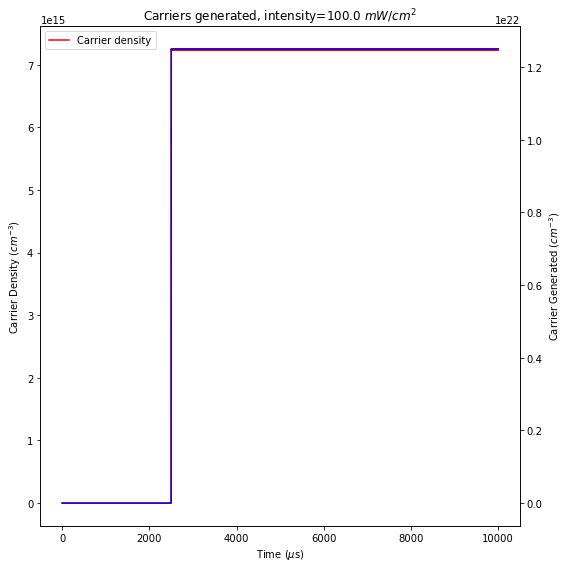

In [3]:
# Plot the result
device.plot()